In [11]:
# import the necessary libraries
import os
import groq 
from dotenv import find_dotenv, load_dotenv
from langgraph_supervisor import create_supervisor
from langchain.agents import create_agent
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq
from langchain.tools import tool
from langchain_experimental.utilities import PythonREPL
from typing import Annotated
import matplotlib.pyplot as plt
import pandas as pd
load_dotenv(find_dotenv())
groq.api_key = os.getenv("OPENAI_API_KEY")
TAVILY_API_KEY=os.getenv("TAVILY_API_KEY")
search_tool=TavilySearchResults(tavily_api_key=TAVILY_API_KEY)
llm = ChatGroq(model="qwen/qwen3-32b")
repl = PythonREPL()

In [12]:
# The @tool decorator from LangChain makes it easy to turn a Python function into a tool 
# that an agent can use

from typing import Annotated
from langchain_core.tools import tool
@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}" 
    
    result_str = f"Successfully executed:\n```python\n{code}\n```\nStdout: {result}"
    return (
        result_str + "\n\nIf you have completed all tasks, respond with FINAL ANSWER."
    )

In [13]:
research_agent = create_agent(
    model=llm, 
    name="research_agent",
    tools=[search_tool], 
    )

In [14]:
code_agent=create_agent(
    model=llm,
    name="code_agent",
    tools=[python_repl_tool],
    )

In [15]:
workflow = create_supervisor(
    [research_agent, code_agent],
    model=llm,
    prompt=(
        "You are a team supervisor managing a research expert and a math expert. "
        "For research, use research_agent. "
        "For creating charts, use code_agent."
    )
)

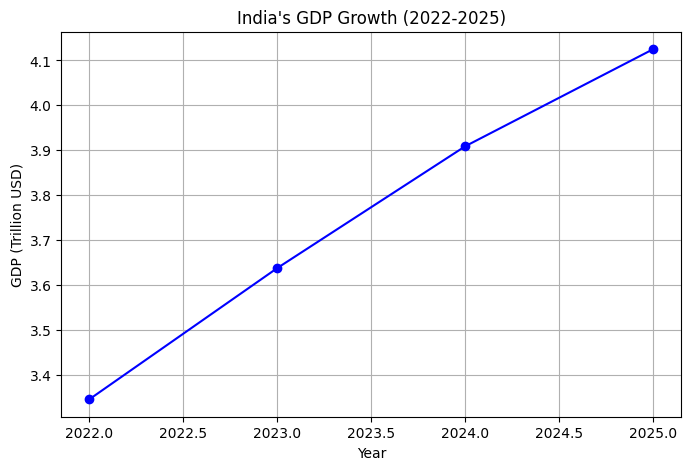

{'messages': [HumanMessage(content="what's the GDP of India in 2022,2023,2024,2025 draw a line chart", additional_kwargs={}, response_metadata={}, id='36d7f126-e5a7-4a60-964c-e0e9522d5f48'),
  AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking for India's GDP for the years 2022, 2023, 2024, and 2025, and wants a line chart. Let me break this down.\n\nFirst, I need to get the GDP data for those years. For 2022 and 2023, there might be actual data available from sources like the World Bank or IMF. However, 2024 and 2025 are future years, so the data isn't available yet. I should check if there are any forecasts or projections for those years. \n\nI should use the research_agent to find the actual GDP figures for 2022 and 2023. Then, for 2024 and 2025, I might need to look for economic forecasts. If there are no projections, I'll have to note that those are estimates. \n\nOnce I have the data, I can pass it to the code_agent to create a line chart. The

In [17]:
app = workflow.compile()
app.invoke({
    "messages": [
        {
            "role": "user",
            "content": "what's the GDP of India in 2022,2023,2024,2025 draw a line chart"
        }
    ]
})